In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from tqdm import tqdm  

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Обучение пройдет на : {device}")

Обучение пройдет на : cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = OxfordIIITPet(root='data/', split='trainval', transform=transform, download=True)
test_dataset = OxfordIIITPet(root='data/', split='test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 792M/792M [00:44<00:00, 17.6MB/s] 
100%|██████████| 19.2M/19.2M [00:01<00:00, 13.1MB/s]


In [ ]:
model = models.efficientnet_b4(pretrained=True)  # Использую предобученную модель
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 37)  # Меняю выходной слой
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# Функция обучения модели
def train_model(epochs=10):
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Эпоха {epoch+1}/{epochs}')
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({'loss': running_loss / (epoch + 1)})
        
        scheduler.step()
        
        accuracy = validate_model()
        print(f"Эпоха {epoch+1}, Качество на тесте: {accuracy:.2f}%")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Лучшее Accuracy: {best_accuracy:.2f}%")

# Функция валидации модели
def validate_model():
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

In [ ]:
train_model(epochs=10)

Using device: cuda


100%|██████████| 792M/792M [00:26<00:00, 29.7MB/s] 
100%|██████████| 19.2M/19.2M [00:01<00:00, 15.8MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 141MB/s] 
Epoch 1/10: 100%|██████████| 115/115 [

Epoch 1, Val Accuracy: 85.17%


Epoch 2/10: 100%|██████████| 115/115 [01:07<00:00,  1.70it/s, loss=22.9]


Epoch 2, Val Accuracy: 89.62%


Epoch 3/10: 100%|██████████| 115/115 [01:09<00:00,  1.65it/s, loss=7.21]


Epoch 3, Val Accuracy: 90.00%


Epoch 4/10: 100%|██████████| 115/115 [01:10<00:00,  1.64it/s, loss=3.32] 


Epoch 4, Val Accuracy: 89.83%


Epoch 5/10: 100%|██████████| 115/115 [01:09<00:00,  1.64it/s, loss=1.71]


Epoch 5, Val Accuracy: 88.96%


Epoch 6/10: 100%|██████████| 115/115 [01:10<00:00,  1.64it/s, loss=0.994]


Epoch 6, Val Accuracy: 90.32%


Epoch 7/10: 100%|██████████| 115/115 [01:10<00:00,  1.64it/s, loss=0.573]


Epoch 7, Val Accuracy: 90.79%


Epoch 8/10: 100%|██████████| 115/115 [01:10<00:00,  1.64it/s, loss=0.409] 


Epoch 8, Val Accuracy: 90.92%


Epoch 9/10: 100%|██████████| 115/115 [01:09<00:00,  1.65it/s, loss=0.361]


Epoch 9, Val Accuracy: 90.79%


Epoch 10/10: 100%|██████████| 115/115 [01:10<00:00,  1.64it/s, loss=0.338]


Epoch 10, Val Accuracy: 90.79%
Best Accuracy: 90.92%


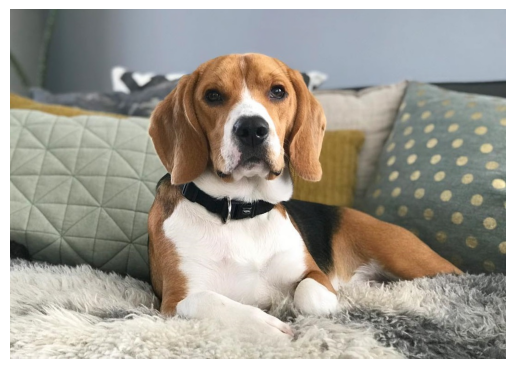

In [22]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def load_and_prepare_image(url_or_path, transform):
    if url_or_path.startswith(('http:', 'https:')):
        response = requests.get(url_or_path)
        img = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        img = Image.open(url_or_path).convert('RGB')
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img_tensor = transform(img).unsqueeze(0).to(device)  
    return img_tensor

image_url = "https://petsitters.by/uploads/c/0/6/2/6/2/f/d/f/9/2/4/8/f/3/2/3/f/3/f/e/f/0/2/4/c/9/f/1/9/8/b/image1716907034_wadPeCoXqL1DMTnW.jpg"
input_image = load_and_prepare_image(image_url, transform)

In [23]:
def predict_image(model, image_tensor, class_names):
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        class_idx = predicted.item()
        confidence = torch.nn.functional.softmax(output, dim=1)[0][class_idx].item()
        return class_names[class_idx], confidence

model.eval()
class_names = train_dataset.classes

predicted_class, confidence = predict_image(model, input_image, class_names)
print(f"На картинке: {predicted_class} (Уверенность модели: {confidence:.2%})")

На картинке: Beagle (Уверенность модели: 99.76%)


In [4]:
train_dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']